<a href="https://colab.research.google.com/github/SeeBook2022/SeeBook-OCR/blob/model_design/stage1_to_3_combine_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 환경설정

In [11]:
import re
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
%matplotlib inline

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 11162, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 11162 (delta 0), reused 4 (delta 0), pack-reused 11158
Receiving objects: 100% (11162/11162), 11.11 MiB | 33.87 MiB/s, done.
Resolving deltas: 100% (7717/7717), done.


In [3]:
!cd yolov5; pip install -qr requirements.txt

     |████████████████████████████████| 596 kB 26.8 MB/s 


In [2]:
!pip install --upgrade google-api-python-client

In [3]:
!pip install google-cloud-vision

In [4]:
# google api key 가져오기

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/drive/MyDrive/Aiffel_Hakathon/my_google_api_key.json'

In [5]:
def file_sorted(files):
    temp = [re.split(r"([0-9]+)", s) for s in files]
    sort = sorted(temp, key = lambda x: (x[0].lower(), int(x[1])))
    
    return [''.join(s) for s in sort]

In [6]:
def make_file_paths(path):
    img_names = os.listdir(path)
    file_names = file_sorted(img_names)
    file_paths = []
    for file_name in file_names:
        file_paths.append(path + file_name)

    return file_paths

In [7]:
def make_imglist(dir_path):
    img_list = []
    file_paths = make_file_paths(dir_path)
    for file_path in file_paths:
        img_array = cv2.imread(file_path)[...,::-1]
        img_list.append(img_array)

    return img_list

### stage1. bookspine detection

In [8]:
# 모델 불러오기
stage1_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage1/stage1_weights/stage1_m_epochs_50.pt')
# 모델 파라미터 설정
stage1_model.conf = 0.3

# 이미지 불러오기
img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test9.jpg'
img = cv2.imread(img_path)[..., ::-1]

# detection + 결과값 저장
results = stage1_model(img)
stage1_df = results.pandas().xyxy[0]

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [9]:
stage1_df

,xmin,ymin,xmax,ymax,confidence,class,name
0,3062.533203,460.639313,3352.881836,2846.541016,0.916416,0,book
1,32.310631,496.157654,344.480377,2820.554443,0.907101,0,book
2,361.894684,259.681488,582.083130,2834.066162,0.904961,0,book
3,2608.677734,301.926270,2824.688232,2839.887207,0.904796,0,book
4,2834.112061,315.739807,3064.493408,2842.245850,0.902816,0,book
5,3782.555420,363.990417,3992.622559,2833.960449,0.898514,0,book
6,1029.406006,441.842651,1298.933472,2857.672119,0.897019,0,book
7,584.086792,345.289520,798.440796,2861.591553,0.896821,0,book
8,2320.766113,317.667023,2599.221436,2869.635742,0.889003,0,book
9,1808.070923,291.587036,2029.551025,2916.653076,0.863277,0,book


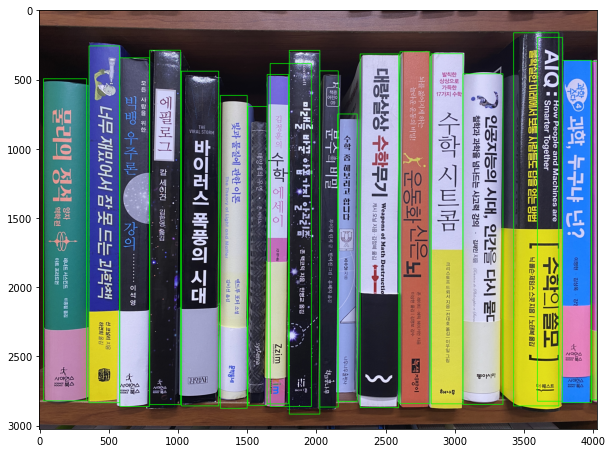

In [12]:
# stage1 모델 결과 시각화

img_file_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test9.jpg'
img = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
green = (0, 255, 0)

for i in range(stage1_df.shape[0]):
    bbox = stage1_df.iloc[i][:4].tolist()
    img_show = cv2.rectangle(img_rgb, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color = green, thickness = 4) # label_bbox 표시 
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.show()

### stage1.5 choose bbox

In [13]:
# ex. 0~3번 index의 bbox 선택을 가정

stage1_bbox_list = []

for i in range(4):
    stage1_bbox_list.append(stage1_df.iloc[i][:4].tolist())

stage1_bbox_list

[[3062.533203125, 460.6393127441406, 3352.8818359375, 2846.541015625],
 [32.310630798339844,
  496.15765380859375,
  344.4803771972656,
  2820.554443359375],
 [361.8946838378906, 259.6814880371094, 582.0831298828125, 2834.066162109375],
 [2608.677734375, 301.92626953125, 2824.688232421875, 2839.88720703125]]

### stage1.5 crop image

In [14]:
# 선택한 bbox만큼 이미지를 크롭

stage1_to_stage2 = []

for bbox_coord in stage1_bbox_list:
    img_crop = img[int(bbox_coord[1]):int(bbox_coord[3]), int(bbox_coord[0]):int(bbox_coord[2])].copy()
    stage1_to_stage2.append(img_crop)

stage1_to_stage2

[array([[[242, 204, 204],
         [245, 207, 207],
         [245, 207, 207],
         ...,
         [ 25,  12,  14],
         [ 26,  13,  15],
         [ 24,  11,  13]],
 
        [[239, 201, 201],
         [242, 204, 204],
         [245, 207, 207],
         ...,
         [ 29,  16,  18],
         [ 33,  20,  22],
         [ 33,  20,  22]],
 
        [[242, 204, 204],
         [245, 207, 207],
         [245, 207, 207],
         ...,
         [ 32,  19,  21],
         [ 36,  23,  25],
         [ 35,  22,  24]],
 
        ...,
 
        [[ 45,  66, 104],
         [ 43,  66, 104],
         [ 44,  67, 105],
         ...,
         [ 39,  64, 104],
         [ 38,  63, 103],
         [ 41,  66, 106]],
 
        [[ 45,  66, 104],
         [ 40,  63, 101],
         [ 38,  61,  99],
         ...,
         [ 38,  63, 103],
         [ 39,  64, 104],
         [ 44,  69, 109]],
 
        [[ 43,  64, 102],
         [ 38,  59,  97],
         [ 31,  54,  92],
         ...,
         [ 39,  64, 104],
  

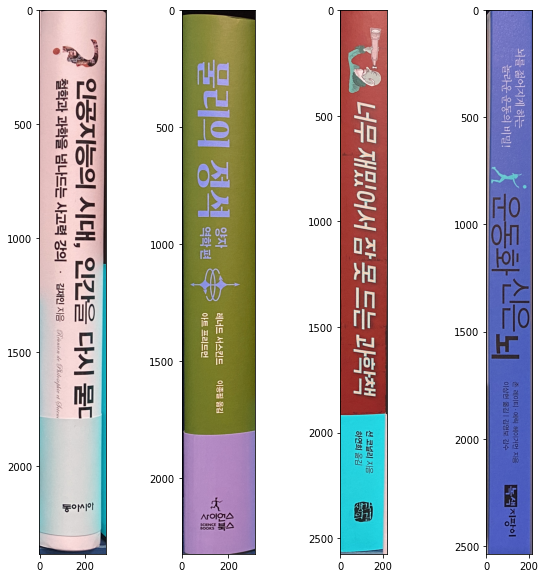

In [15]:
# 이미지 크롭 결과 시각화

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
ax1.imshow(stage1_to_stage2[0])
ax2.imshow(stage1_to_stage2[1])
ax3.imshow(stage1_to_stage2[2])
ax4.imshow(stage1_to_stage2[3])
fig.show()


### stage2. booktitle detection

In [17]:
# stage2 모델 설정
stage2_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage2_iou_test/stage2_final.pt')
stage2_model.max_det = 1
stage2_model.conf = 0.3

stage2_bbox_coord_list = []

# detection + 결과를 리스트로 저장
results = stage2_model(stage1_to_stage2)
stage2_df = results.pandas().xyxy
for i, row in enumerate(stage2_df):
    stage2_bbox_coord_list.append(row.iloc[0].tolist()[:4])

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [18]:
stage2_bbox_coord_list

[[106.5059814453125, 264.0466613769531, 268.6954040527344, 1828.8087158203125],
 [41.060115814208984,
  180.2122039794922,
  246.93450927734375,
  1272.270263671875],
 [34.526344299316406, 405.8883972167969, 193.5505828857422, 1838.32763671875],
 [27.429428100585938,
  803.0581665039062,
  206.11404418945312,
  1657.4779052734375]]

In [19]:
# 제목 부분 크롭

stage2_to_stage3 = []
for i, stage1_crop in enumerate(stage1_to_stage2):
    stage2_img_crop = stage1_crop[int(stage2_bbox_coord_list[i][1]):int(stage2_bbox_coord_list[i][3]), int(stage2_bbox_coord_list[i][0]):int(stage2_bbox_coord_list[i][2])].copy()
    stage2_to_stage3.append(stage2_img_crop)

stage2_to_stage3

[array([[[247, 213, 213],
         [247, 213, 213],
         [247, 213, 213],
         ...,
         [216, 176, 177],
         [221, 180, 178],
         [218, 177, 175]],
 
        [[248, 214, 214],
         [246, 212, 212],
         [247, 213, 213],
         ...,
         [215, 175, 176],
         [221, 180, 178],
         [217, 176, 174]],
 
        [[248, 214, 214],
         [245, 211, 211],
         [247, 213, 213],
         ...,
         [216, 174, 175],
         [218, 177, 175],
         [215, 174, 172]],
 
        ...,
 
        [[217, 213, 212],
         [216, 212, 211],
         [217, 213, 212],
         ...,
         [136, 217, 222],
         [140, 222, 227],
         [138, 225, 229]],
 
        [[216, 212, 211],
         [217, 213, 212],
         [216, 212, 211],
         ...,
         [136, 217, 222],
         [138, 220, 225],
         [139, 226, 230]],
 
        [[215, 211, 210],
         [218, 214, 213],
         [216, 212, 211],
         ...,
         [135, 216, 221],
  

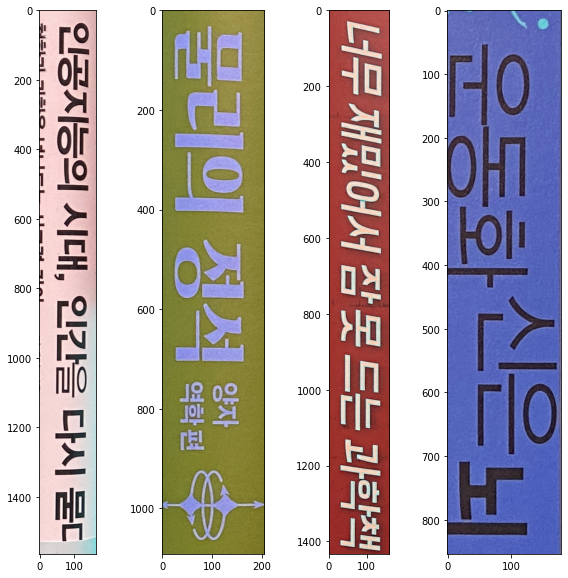

In [20]:
# stage2 결과 시각화

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
ax1.imshow(stage2_to_stage3[0])
ax2.imshow(stage2_to_stage3[1])
ax3.imshow(stage2_to_stage3[2])
ax4.imshow(stage2_to_stage3[3])
fig.show()


### stage3. title OCR

In [21]:
def detect_text(img_bytes):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    # with io.open(path, 'rb') as image_file:
    #     content = image_file.read()
        
    image = vision.Image(content=img_bytes) # byte로 받아서 바로 실행

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    # 제목을 한 문장으로 추출할 수 있도록 코드 수정 (공백 제거)
    result = ''
    for idx, text in enumerate(texts):
        if idx > 0: result += text.description 
    return result

    # if response.error.message:
    #     raise Exception(
    #         '{}\nFor more info on error messages, check: '
    #         'https://cloud.google.com/apis/design/errors'.format(
    #             response.error.message))

In [22]:
# 이미지 변환 함수1(grayscale, bright, contrast)

def img2gray(image_array):
    img_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    add_dst = cv2.add(img_gray, 100) # 밝기 조절
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4)) # 대비 조절
    gray_cont_dst = clahe.apply(add_dst)

    img_bytes = cv2.imencode('.jpg', gray_cont_dst)[1].tobytes()

    return img_bytes

In [26]:
# 이미지 변환 함수2(grayscale, resize, bright)

def img2gray2(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 흑백 처리
    img_gray = cv2.resize(img_gray, dsize=(0,0), fx = 1.5, fy= 1.5, interpolation=cv2.INTER_AREA) # resize
    add_dst = cv2.add(img_gray, 30) # 밝기 조절
    
    img_bytes = cv2.imencode('.jpg', add_dst)[1].tobytes()

    return img_bytes

In [30]:
# 특수문자 제거 함수

def preprocess_sentence(sentence):
    sentence = re.sub('[-=+,「#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', sentence)
    sentence = sentence.replace(' ', '') # 공백 제거
    sentence = sentence.strip() # 양쪽 공백 제거
    return sentence

In [31]:
stage3_result = []
for img_array in stage2_to_stage3:
    img_transform = img2gray2(img_array) # 이미지 변환 적용
    stage3_output = detect_text(img_transform) # ocr 적용
    stage3_result.append(preprocess_sentence(stage3_output)) # 특수문자 제거

In [32]:
stage3_result

['인공지능의시대인간을다시묻디', '물리의정석양자역학편', '너무재밌어서잠못드는과학책', '운동화신은뇌']

### stage1 to stage3 결합

In [33]:
# 모델 설정하기

stage1_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage1/stage1_weights/stage1_m_epochs_50.pt')
stage1_model.conf = 0.3

stage2_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage2_iou_test/stage2_final.pt')
stage2_model.max_det = 1
stage2_model.conf = 0.3

# 이미지 로드하기
img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_path)[..., ::-1]

# 선택할 책 개수 설정
img_select = 10

# -----------------------------------------------------------------------------

# stage1. bookspine detection

results = stage1_model(img)
stage1_df = results.pandas().xyxy[0]

# bbox 선택
# ex. 0~3번 index의 bbox 선택을 가정
stage1_bbox_coord_list = []

for i in range(img_select):
    stage1_bbox_coord_list.append(stage1_df.iloc[i][:4].tolist())

# stage1에서 stage2로 보낼 이미지 크롭
stage1_to_stage2 = []

for stage1_bbox in stage1_bbox_coord_list:
    spine_crop = img[int(stage1_bbox[1]):int(stage1_bbox[3]), int(stage1_bbox[0]):int(stage1_bbox[2])].copy()
    stage1_to_stage2.append(spine_crop)

# -----------------------------------------------------------------------------

# stage2. booktitle detection

stage2_bbox_coord_list = []

results = stage2_model(stage1_to_stage2)
stage2_df = results.pandas().xyxy
for i, row in enumerate(stage2_df):
    stage2_bbox_coord_list.append(row.iloc[0].tolist()[:4]) # 리스트 만드는 과정을 통합

# stage2에서 stage3로 보낼 이미지 크롭
stage2_to_stage3 = []
for i, stage1_crop in enumerate(stage1_to_stage2):
    stage2_img_crop = stage1_crop[int(stage2_bbox_coord_list[i][1]):int(stage2_bbox_coord_list[i][3]), int(stage2_bbox_coord_list[i][0]):int(stage2_bbox_coord_list[i][2])].copy()
    stage2_to_stage3.append(stage2_img_crop)

# -----------------------------------------------------------------------------

# stage3. Title OCR

stage3_start = time.time()

stage3_result = []
for img_array in stage2_to_stage3:
    img_transform = img2gray2(img_array) # 이미지 변환 적용
    stage3_output = detect_text(img_transform) # ocr 적용
    stage3_result.append(preprocess_sentence(stage3_output)) # 특수문자 제거

# 최종 결과
stage3_result

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


['리아의딸들',
 '이명현의과학책방',
 '',
 '처재과학자들의숨겨진이야기',
 '원자인간을완성하다',
 '물리학자는영화에서과학을본다어스',
 '세상을움직이는비밀수와기하문명과수학',
 '신은수학자인가А',
 '미생물이플라톤을만났을때',
 '물리학은처음인데요']

### Inference time 측정
- 최소 1권 ~ 최대 10권

In [34]:
# 모델 설정하기

stage1_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage1/stage1_weights/stage1_m_epochs_50.pt')
stage1_model.conf = 0.3

stage2_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_test_ver2/stage2_iou_test/stage2_final.pt')
stage2_model.max_det = 1
stage2_model.conf = 0.3

# 이미지 로드하기
img_path = '/content/drive/MyDrive/Aiffel_Hakathon/3rd_hackathon/model_combine/stage1_test_image/test6.jpg'
img = cv2.imread(img_path)[..., ::-1]

# 선택한 이미지 개수
img_select = 10

# -----------------------------------------------------------------------------

for select_num in range(img_select):

    # stage1. bookspine detection
    
    stage1_start = time.time()

    results = stage1_model(img)
    stage1_df = results.pandas().xyxy[0]

    # bbox 선택
    # ex. 0~3번 index의 bbox 선택을 가정
    stage1_bbox_coord_list = []

    for i in range(select_num+1):
        stage1_bbox_coord_list.append(stage1_df.iloc[i][:4].tolist())

    # stage1에서 stage2로 보낼 이미지 크롭
    stage1_to_stage2 = []

    for stage1_bbox in stage1_bbox_coord_list:
        spine_crop = img[int(stage1_bbox[1]):int(stage1_bbox[3]), int(stage1_bbox[0]):int(stage1_bbox[2])].copy()
        stage1_to_stage2.append(spine_crop)

    stage1_end = time.time()
    print(f'stage1({select_num+1}권) : {stage1_end - stage1_start}')


    # -----------------------------------------------------------------------------

    # stage2. booktitle detection

    stage2_start = time.time()

    stage2_bbox_coord_list = []

    results = stage2_model(stage1_to_stage2)
    stage2_df = results.pandas().xyxy
    for i, row in enumerate(stage2_df):
        stage2_bbox_coord_list.append(row.iloc[0].tolist()[:4]) # 리스트 만드는 과정을 통합

    # stage2에서 stage3로 보낼 이미지 크롭
    stage2_to_stage3 = []
    for i, stage1_crop in enumerate(stage1_to_stage2):
        stage2_img_crop = stage1_crop[int(stage2_bbox_coord_list[i][1]):int(stage2_bbox_coord_list[i][3]), int(stage2_bbox_coord_list[i][0]):int(stage2_bbox_coord_list[i][2])].copy()
        stage2_to_stage3.append(stage2_img_crop)

    stage2_end = time.time()
    print(f'stage2({select_num+1}권) : {stage2_end - stage2_start}')

    # -----------------------------------------------------------------------------

    # stage3. Title OCR

    stage3_start = time.time()

    stage3_result = []
    for img_array in stage2_to_stage3:
        img_transform = img2gray2(img_array) # 이미지 변환 적용
        stage3_output = detect_text(img_transform) # ocr 적용
        stage3_result.append(preprocess_sentence(stage3_output)) # 특수문자 제거

    stage3_end = time.time()
    print(f'stage3({select_num+1}권) : {stage3_end - stage3_start}')
    print(f'Total time({select_num+1}권) : {stage3_end - stage1_start}')
    print('stage3_result : ', stage3_result)
    print('-'*30)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-3-4 torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


stage1(1권) : 0.13118648529052734
stage2(1권) : 0.02302098274230957
stage3(1권) : 0.6916441917419434
Total time(1권) : 0.8460540771484375
stage3_result :  ['리아의딸들']
------------------------------
stage1(2권) : 0.13356399536132812
stage2(2권) : 0.027008056640625
stage3(2권) : 2.1838276386260986
Total time(2권) : 2.345038414001465
stage3_result :  ['리아의딸들', '이명현의과학책방']
------------------------------
stage1(3권) : 0.1412663459777832
stage2(3권) : 0.029658079147338867
stage3(3권) : 1.738081693649292
Total time(3권) : 1.909184455871582
stage3_result :  ['리아의딸들', '이명현의과학책방', '']
------------------------------
stage1(4권) : 0.14301347732543945
stage2(4권) : 0.030728816986083984
stage3(4권) : 3.013110637664795
Total time(4권) : 3.1870362758636475
stage3_result :  ['리아의딸들', '이명현의과학책방', '', '처재과학자들의숨겨진이야기']
------------------------------
stage1(5권) : 0.1497790813446045
stage2(5권) : 0.04840660095214844
stage3(5권) : 3.145007610321045
Total time(5권) : 3.343411684036255
stage3_result :  ['리아의딸들', '이명현의과학책방', '', '처